# NEON data skills - week 3 RGB assignment
## Set up
We start this exercise with checking that we have activated the correct kernel (Python 3.5, **not** the standard Python 3.6), and importing the necessary libraries.

In [10]:
import sys
sys.version

'3.5.5 |Anaconda custom (64-bit)| (default, Apr 26 2018, 08:11:22) \n[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]'

We need to import packages/modules to work with geospatial data. GDAL, Geospatial Data Abstraction Library, is a module to read and write geospatial data (both vector and raster). OSR is a module to deal with spatial references. Technically, both these modules are part of the `osgeo` package.  See http://www.gdal.org/, https://www.osgeo.org/ or http://gdal.org/python/osgeo-module.html for more information. 

In [11]:
import gdal
import osr

We now import packages needed for calculations (NumPy) and plotting (MatPlotLib). Using the `as` command means that commands from these packages needed to have `np.` or `plt.` prefixed to it. This is to ensure that commands with the same names from different packages do not clash with each other. The `%matplotlib inline` is a 'magic' function: it ensures that plots are plotted inline in the notebook.
The `warnings` package helps in surpressing non-fatal errors (associated with backwards incompatible changes coming with Python 3.0) that would otherwise show up repeatedly.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Reading in RGB data
We define the function that will generate numerical information (and metadata) from an RGB geotif.

In [13]:
def RGBraster2array(RGB_geotif):
    """RGBraster2array reads in a NEON AOP geotif file and returns 
    a numpy array, and header containing associated metadata with spatial information.
    --------
    Parameters
        RGB_geotif -- full or relative path and name of reflectance hdf5 file
    --------
    Returns 
    --------
    array:
        numpy array of geotif values
    metadata:
        dictionary containing the following metadata (all strings):
            array_rows
            array_cols
            bands
            driver
            projection
            geotransform 
            pixelWidth 
            pixelHeight 
            extent
            noDataValue  
            scaleFactor 
    --------
    Example Execution:
    --------
    RGB_geotif = '2017_SERC_2_368000_4306000_image.tif'
    RGBcam_array, RGBcam_metadata = RGBraster2array(RGB_geotif) """

    metadata = {}
    dataset = gdal.Open(RGB_geotif)
    metadata['array_rows'] = dataset.RasterYSize
    metadata['array_cols'] = dataset.RasterXSize
    metadata['bands'] = dataset.RasterCount
    metadata['driver'] = dataset.GetDriver().LongName
    metadata['projection'] = dataset.GetProjection()
    metadata['geotransform'] = dataset.GetGeoTransform()

    mapinfo = dataset.GetGeoTransform()
    metadata['pixelWidth'] = mapinfo[1]
    metadata['pixelHeight'] = mapinfo[5]

    metadata['ext_dict'] = {}
    metadata['ext_dict']['xMin'] = mapinfo[0]
    metadata['ext_dict']['xMax'] = mapinfo[0] + dataset.RasterXSize/mapinfo[1]
    metadata['ext_dict']['yMin'] = mapinfo[3] + dataset.RasterYSize/mapinfo[5]
    metadata['ext_dict']['yMax'] = mapinfo[3]

    metadata['extent'] = (metadata['ext_dict']['xMin'],metadata['ext_dict']['xMax'],
                          metadata['ext_dict']['yMin'],metadata['ext_dict']['yMax'])

    raster = dataset.GetRasterBand(1)
    array_shape = raster.ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float).shape
    metadata['noDataValue'] = raster.GetNoDataValue()
    metadata['scaleFactor'] = raster.GetScale()

    array = np.zeros((array_shape[0],array_shape[1],dataset.RasterCount),'uint8') #pre-allocate stackedArray matrix
    for i in range(1, dataset.RasterCount+1):
        band = dataset.GetRasterBand(i).ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float)
        band[band==metadata['noDataValue']]=np.nan
        band = band/metadata['scaleFactor']
        array[...,i-1] = band

    return array, metadata

To use the function, we first load the RGB geotif downloaded from NEON.

In [16]:
RGB_geotif = './2017_SERC_2_368000_4306000_image.tif'

Next, we apply the function to it. Note - if the notebook shows `[*]` in front of the line you ran, it means the kernel is busy. For the function below it takes slightly longer to run than the previous lines, so wait until the notebook shows `[8]` (or some other number in the brackets).

In [17]:
SERC_RGBcam_array, SERC_RGBcam_metadata = RGBraster2array(RGB_geotif)

To look at the dimensions of this tile, use `.shape`. The information below tells us that this array has 10,000 rows and 10,000 columns. Arrays can be multidimensional, and in this case it is: the third value tells us there are 3 values (R, G and B band values) associated with the array 'cells'. 

In [23]:
SERC_RGBcam_array.shape

(10000, 10000, 3)

To look at the metadata, use `.keys` to look at the dictionary keys.

In [20]:
for key in sorted(SERC_RGBcam_metadata.keys()):
  print(key)

array_cols
array_rows
bands
driver
ext_dict
extent
geotransform
noDataValue
pixelHeight
pixelWidth
projection
scaleFactor


## Plotting RGB data
The next function defines how to plot the data

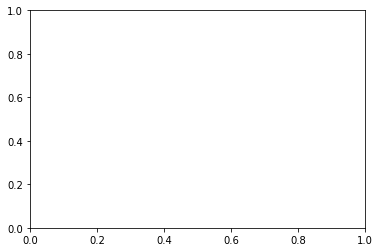

In [21]:
def plot_band_array(band_array,
                    refl_extent,
                    colorlimit,
                    ax=plt.gca(),
                    title='',
                    cbar ='on',
                    cmap_title='',
                    colormap='spectral'):

    '''plot_band_array reads in and plots a single band or an rgb band combination of a reflectance array
    --------
    Parameters
    --------
        band_array: flightline array of reflectance values, created from h5refl2array function
        refl_extent: extent of reflectance data to be plotted (xMin, xMax, yMin, yMax) - use metadata['extent'] 
        from h5refl2array function
        colorlimit: range of values to plot (min,max). Best to look at the histogram of reflectance values 
        before plotting to determine colorlimit.
        ax: optional, default = current axis
        title: string, optional; plot title
        cmap_title: string, optional; colorbar title
        colormap: string, optional; see https://matplotlib.org/examples/color/colormaps_reference.html for list 
        of colormaps
    --------
    Returns 
        plots array of single band or RGB if given a 3-band 
    --------
    Example:
    --------
    plot_band_array(SERC_RGBcam_array, 
                    SERC_RGBcam_metadata['extent'],
                    (1,255),
                    title='SERC RGB Camera Tile',
                    cbar='off')'''

    plot = plt.imshow(band_array,extent=refl_extent,clim=colorlimit); 
    if cbar == 'on':
        cbar = plt.colorbar(plot,aspect=40); plt.set_cmap(colormap); 
        cbar.set_label(cmap_title,rotation=90,labelpad=20)
    plt.title(title); ax = plt.gca(); 
    ax.ticklabel_format(useOffset=False, style='plain'); #do not use scientific notation #
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90); #rotate x tick labels 90 degrees

We apply this function to the data we extracted. The first argument is the data we extracted (as an array), the second the extent as defined in the metadata. The third is the color limit (in this case set to all), the fourth a title for our plot, and lastly the option to have a colorscale in the legend is turned off.

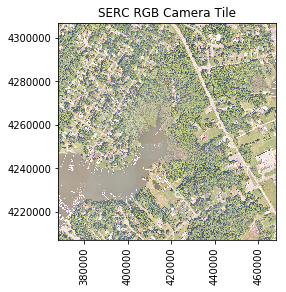

In [26]:
plot_band_array(SERC_RGBcam_array,
                SERC_RGBcam_metadata['extent'],
                (1,255),
                title='SERC RGB Camera Tile',
                cbar='off') 

## Extract and plot band values
We can also extract values for the separate bands. To plot a histogram of values for the first band (red), we need to select all rows and columns with `:` and select the first values (this is called 'splicing'). Since Python indexes starting with 0, you use `0` (so red is indexed at `0`, green at `1` and blue at `2`). The command `ravel` ensures that a 1-D array is returned.
We are creating a histogram with 20 bins.

Text(0,0.5,'Frequency')

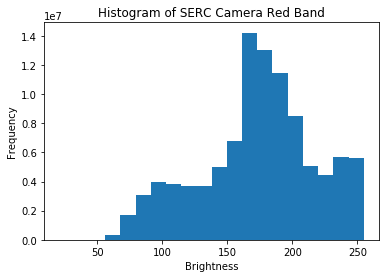

In [46]:
plt.hist(np.ravel(SERC_RGBcam_array[:,:,0]),20);
plt.title('Histogram of SERC Camera Red Band')
plt.xlabel('Brightness'); plt.ylabel('Frequency')

## Challenge exercises
### Plot histograms of green and blue bands
As indicated earlier, for green bands we need to use index `1` and for blue index `2`.

Text(0,0.5,'Frequency')

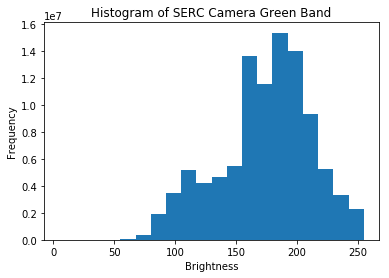

In [47]:
plt.hist(np.ravel(SERC_RGBcam_array[:,:,1]),20);
plt.title('Histogram of SERC Camera Green Band')
plt.xlabel('Brightness'); plt.ylabel('Frequency')

Text(0,0.5,'Frequency')

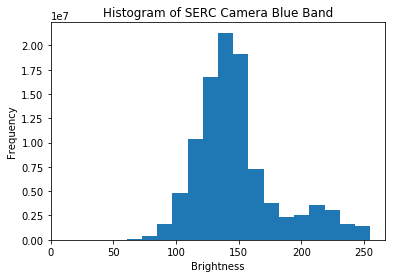

In [49]:
plt.hist(np.ravel(SERC_RGBcam_array[:,:,2]),20);
plt.title('Histogram of SERC Camera Blue Band')
plt.xlabel('Brightness'); plt.ylabel('Frequency')

### Data exploration
#### Minimum and maximum reflectance for each band
Minimum and maximum for the red band:

In [54]:
np.amin(SERC_RGBcam_array[:,:,0]), np.amax(SERC_RGBcam_array[:,:,0])

(21, 255)

Minimum and maximum for the green band:

In [55]:
np.amin(SERC_RGBcam_array[:,:,1]), np.amax(SERC_RGBcam_array[:,:,1])

(5, 255)

Minimum and maximum for the blue band:

In [56]:
np.amin(SERC_RGBcam_array[:,:,1]), np.amax(SERC_RGBcam_array[:,:,1])

(5, 255)

#### UTM zone

In [57]:
SERC_RGBcam_metadata['projection']

'PROJCS["WGS 84 / UTM zone 18N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32618"]]'

The Universe Transverse Mercator (UTM) zone is defined as `18N`, which corresponds to 72 - 78 degrees W, and from the North Pole to the equator. See http://www.spatialreference.org/ref/epsg/wgs-84-utm-zone-18n/ or https://epsg.io/32618

#### Plot each band separately
To plot each band separately, we use the same code as before, but with splicing we select the bands we need. We start with the red band. The legend is not shown, but low values are blue and high values are yellow.

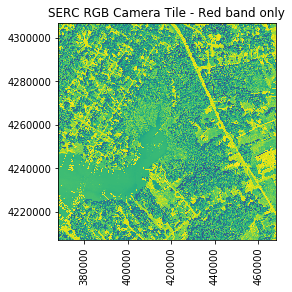

In [58]:
plot_band_array(SERC_RGBcam_array[:,:,0],
                SERC_RGBcam_metadata['extent'],
                (1,255),
                title='SERC RGB Camera Tile - Red band only',
                cbar='off') 

Now the green band.

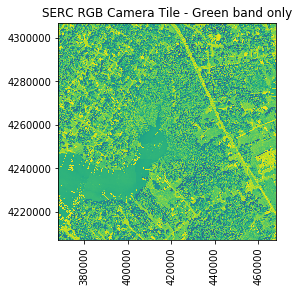

In [59]:
plot_band_array(SERC_RGBcam_array[:,:,1],
                SERC_RGBcam_metadata['extent'],
                (1,255),
                title='SERC RGB Camera Tile - Green band only',
                cbar='off') 

And lastly the blue band.

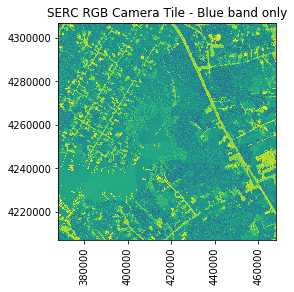

In [62]:
plot_band_array(SERC_RGBcam_array[:,:,2],
                SERC_RGBcam_metadata['extent'],
                (1,255),
                title='SERC RGB Camera Tile - Blue band only',
                cbar='off') 